### 1D Convnet on IMDB Data

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('loading data')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)

Using TensorFlow backend.


loading data
Pad Sequences (samples x time)
('x_train.shape:', (25000, 500))
('x_test.shape:', (25000, 500))


In [2]:
%matplotlib inline

from keras import models
from keras import layers
from keras.optimizers import RMSprop

from util import print_curves

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


def plot_model_jupyter(model):
    SVG(model_to_dot(model).create(prog='dot', format='svg'))


model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 14, activation='relu'))
# default pool size 2
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
plot_model_jupyter(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 85, 32)            14368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,323,105
Trainable params: 1,323,105
Non-trainable params: 0
_________________________________________________________________


In [3]:
plot_model_jupyter(model)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 151us/step - loss: 0.4946 - acc: 0.7414 - val_loss: 0.3218 - val_acc: 0.8626
Epoch 2/10
20000/20000 [==============================] - 2s 77us/step - loss: 0.2538 - acc: 0.8973 - val_loss: 0.3102 - val_acc: 0.8682
Epoch 3/10
20000/20000 [==============================] - 2s 77us/step - loss: 0.1870 - acc: 0.9268 - val_loss: 0.3986 - val_acc: 0.8468
Epoch 4/10
20000/20000 [==============================] - 2s 78us/step - loss: 0.1380 - acc: 0.9484 - val_loss: 0.3312 - val_acc: 0.8782
Epoch 5/10
20000/20000 [==============================] - 2s 78us/step - loss: 0.0963 - acc: 0.9662 - val_loss: 0.3757 - val_acc: 0.8770
Epoch 6/10
20000/20000 [==============================] - 2s 77us/step - loss: 0.0632 - acc: 0.9802 - val_loss: 0.4155 - val_acc: 0.8770
Epoch 7/10
20000/20000 [==============================] - 2s 77us/step - loss: 0.0356 - acc: 0.9901 - val_loss: 0.5837 - val_acc

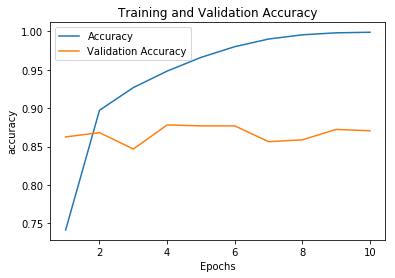

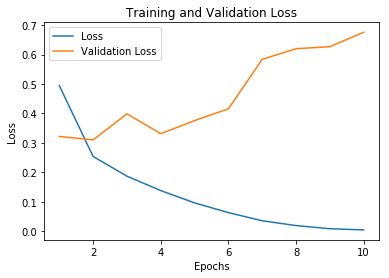

In [4]:
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

print_curves(history)

In [5]:
plot_model_jupyter(model)

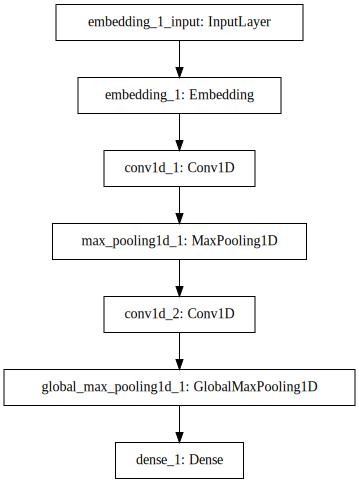

In [6]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 50us/step


[0.74228758404254913, 0.85128000000000004]

### Try on Temperature Dataset

In [8]:
import os
import pandas as pd

data_dir = './Downloads/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
df = pd.read_csv(fname)

In [9]:
df_time = df
df = df.drop('Date Time', axis=1)
mean = df.mean(0)
std = df.std(0)
# standardize data
df = df.sub(mean, axis=1).div(std, axis=1)

In [10]:
import numpy as np


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6,
              reverse=False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    # create offset so we don't see the same 1/step th of data in non-shuffled
    # scenario
    offset = 1

    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                # won't this reset the generator to the same place, esentially not giving us 1/6 of the data?
                # might be somewhat trivial since we're taking hourly samples,
                # so data only has changed by an hour and we're reading across
                # 8 years total dataset
                i = min_index + lookback + offset
                offset += 1
                if offset == step:
                    offset = 0
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        if reverse:
            yield samples[:, ::-1, :], targets
        else:
            yield samples, targets

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
num_features = df.shape[1]

In [12]:
train_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

# how many train steps to see entire dataset
train_steps = (200000 - lookback) // batch_size

# how many val steps to see entire dataset
val_steps = (300000 - 200001 - lookback) // batch_size

# how many test steps to see entire dataset
test_steps = (len(df) - 300001 - lookback) // batch_size

# need to check if we're processing the cursor at all, i.e. are we only
# seeing 1/6 of the data since we're sampling every 6 hours
# Actually, we're shuffling, so that should take care of it, but only for
# training, in theory you want to run through 6 times, offestting,
# something like that

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, df.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,
                              epochs=20, validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4446 - val_loss: 0.4487
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3869 - val_loss: 0.4538
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3632 - val_loss: 0.4645
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3475 - val_loss: 0.4659
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3345 - val_loss: 0.4698
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3265 - val_loss: 0.4705
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3170 - val_loss: 0.4704
Epoch 8/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3112 - val_loss: 0.4805
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3019 - val_loss: 0.4980
Epoch 10/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2970 - val_lo

Min Val Loss: 0.448724445784


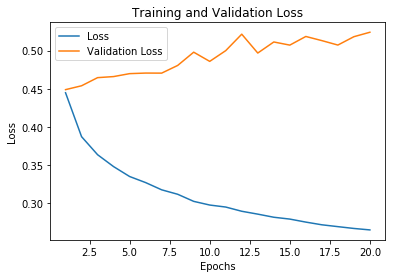

In [14]:
print_curves(history)

Still not as good as naive baseline but fast.

### What if we use 1D Convnet to pre-process / downsample data, then use RNN?

In [15]:
lookback = 1440

# Changed step to 3 so we look at every 30 minutes
step = 3
delay = 144
batch_size = 128
num_features = df.shape[1]

train_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

# how many train steps to see entire dataset
train_steps = (200000 - lookback) // batch_size

# how many val steps to see entire dataset
val_steps = (300000 - 200001 - lookback) // batch_size

# how many test steps to see entire dataset
test_steps = (len(df) - 300001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, df.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,
                              epochs=20, validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 142s 285ms/step - loss: 0.3508 - val_loss: 0.2979
Epoch 2/20
500/500 [==============================] - 143s 287ms/step - loss: 0.3190 - val_loss: 0.2899
Epoch 3/20
500/500 [==============================] - 140s 281ms/step - loss: 0.3036 - val_loss: 0.2855
Epoch 4/20
500/500 [==============================] - 143s 286ms/step - loss: 0.2940 - val_loss: 0.2864
Epoch 5/20
500/500 [==============================] - 146s 292ms/step - loss: 0.2857 - val_loss: 0.2821
Epoch 6/20
500/500 [==============================] - 137s 274ms/step - loss: 0.2815 - val_loss: 0.2889
Epoch 7/20
500/500 [==============================] - 142s 284ms/step - loss: 0.2742 - val_loss: 0.2872
Epoch 8/20
500/500 [==============================] - 142s 284ms/step - loss: 0.2670 - val_loss: 0.2966
Epoch 9/20
500/500 [==============================] - 136s 272ms/step - loss: 0.2627 - val_loss: 0.2904
Epoch 10/20
500/500 [==============================] - 138s 277m

In [ ]:
print_curves(history)

This wasn't as good as regularized GRU alone, but was a lot faster. We also looked at twice as much data - didn't seem to help as much in this case but good strategy to know.